In [5]:
# Import libraries for data handling
import pandas as pd
import numpy as np
import nltk
from nltk.stem import WordNetLemmatizer
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchtext.vocab import Vocab, build_vocab_from_iterator, GloVe
from torchtext.data.utils import get_tokenizer
nltk.download('wordnet')  # Needed for the WordNetLemmatizer
nltk.download('punkt')    # Needed for tokenization
lemmatizer = WordNetLemmatizer()



[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\marti\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\marti\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [6]:
torch.cuda.is_available()


True

In [7]:
train_df = pd.read_csv(r'C:\Deep-Learning-based-Authorship-Identification\project\my_train_7030_1.csv')
test_df = pd.read_csv(r'C:\Deep-Learning-based-Authorship-Identification\project\my_test_7030_1.csv')

In [9]:
df = pd.concat([train_df, test_df], ignore_index=True)

In [10]:
df

,text,author_num
0,What can I recall of her during the past six m...,22
1,“How is Monsieur’s arm?” replied Basque. “Bett...,21
2,It drags hard; I guess he’s holding on. Jerk h...,10
3,"Bless you, _they_ ain't got noth'n' to complai...",15
4,"On leaving Omaha, it passes along the left ban...",12
...,...,...
2295,"Up here were only dark, bare rock slopes and t...",9
2296,"""Oh, Harry, we were sure you were going to -- ...",11
2297,"I han’t seen a way to get you safe, and I’ve l...",4
2298,"Some, in the true spirit of reckless enterpris...",19


In [11]:
import torch
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import DataLoader
from collections import Counter
from torchtext.vocab import build_vocab_from_iterator, GloVe
from torchtext.data.utils import get_tokenizer

def yield_tokens(data_iter):
    tokenizer = get_tokenizer("spacy", language="en_core_web_sm")
    for text in data_iter:
        yield tokenizer(text)

all_texts = list(train_df['text'].str.lower()) + list(test_df['text'].str.lower())
# Build vocabulary
tokenizer = get_tokenizer("spacy", language="en_core_web_sm")
vocab = build_vocab_from_iterator(yield_tokens(all_texts), specials=["<unk>", "<pad>"])
vocab.set_default_index(vocab['<unk>'])  # Handle unknown tokens
glove = GloVe(name='6B', dim=100)
embedding_matrix = torch.zeros((len(vocab), 100))
for word, idx in vocab.get_stoi().items():
    if word in glove.stoi:
        embedding_matrix[idx] = glove.vectors[glove.stoi[word]]
    else:
        embedding_matrix[idx] = torch.randn(100)  # Random initialization for words not in GloVe

In [25]:
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import DataLoader, Dataset

class TextAuthorDataset(Dataset):
    def __init__(self, dataframe, vocab, label_dict):
        self.dataframe = dataframe
        self.vocab = vocab
        self.label_dict = label_dict
        self.tokenizer = get_tokenizer('basic_english')

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        text = self.dataframe.iloc[idx]['text']
        label = self.dataframe.iloc[idx]['author_num']
        text = [self.vocab[token] for token in self.tokenizer(text)]
        return torch.tensor(text, dtype=torch.long), torch.tensor(self.label_dict[label], dtype=torch.long)

author_labels = {name: idx for idx, name in enumerate(df['author_num'].unique())}


train_dataset = TextAuthorDataset(train_df, vocab, author_labels)
test_dataset = TextAuthorDataset(test_df, vocab, author_labels)
def collate_batch(batch):
    texts, labels = zip(*batch)
    lengths = torch.tensor([len(seq) for seq in texts], dtype=torch.long)
    
    texts = pad_sequence(texts, batch_first=True, padding_value=vocab.get_stoi()['<pad>'])  # Adjust padding_value based on your vocab
    labels = torch.tensor(labels, dtype=torch.long)
    
    return texts, lengths, labels


train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, collate_fn=collate_batch)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, collate_fn=collate_batch)



In [26]:
reversed_dict = {
    'Agatha Christie': 0,
    'Arthur Conan Doyle': 1,
    'Austen': 2,
    'Daniel Defoe': 3,
    'Dickens': 4,
    'Emily Bronte': 5,
    'Fitzgerald': 6,
    'Frances Hodgson Burnett': 7,
    'Gaston Leroux': 8,
    'H.P. Lovecraft': 9,
    'Herman Melville': 10,
    'J.K. Rowling': 11,
    'Jules Verne': 12,
    'Leo Tolstoy': 13,
    'Louisa May Alcott': 14,
    'Mark Twain': 15,
    'Mitchell': 16,
    'Montgomery': 17,
    'Robert Louis Stevenson': 18,
    'Shelley': 19,
    'Stoker': 20,
    'Victor Hugo': 21,
    'Wilkie Collins': 22
}

In [27]:
total_dataset = pd.read_csv(r'C:\Deep-Learning-based-Authorship-Identification\data_with_genre.csv')

total_dataset['author_num'] = total_dataset['author'].map(reversed_dict)
total_dataset

,text,book_name,author,genre,author_num
0,Happy families are all alike; every unhappy fa...,Anna_Kerinena,Leo Tolstoy,historical,13
1,"""Ah, ah, ah! Oo!..."" he muttered, recalling ev...",Anna_Kerinena,Leo Tolstoy,historical,13
2,But he felt all the difficulty of his position...,Anna_Kerinena,Leo Tolstoy,historical,13
3,"Stepan Arkadyevitch's eyes asked: ""Why do you ...",Anna_Kerinena,Leo Tolstoy,historical,13
4,"Beg her forgiveness, sir. There's no help for ...",Anna_Kerinena,Leo Tolstoy,historical,13
...,...,...,...,...,...
13149,"He returned after midnight, and, instead of go...",Wuthering_Heights,Emily Bronte,romance,5
13150,“Strange happiness! If you would hear me witho...,Wuthering_Heights,Emily Bronte,romance,5
13151,"The following evening was very wet: indeed, it...",Wuthering_Heights,Emily Bronte,romance,5
13152,"Hareton, with a streaming face, dug green sods...",Wuthering_Heights,Emily Bronte,romance,5


In [28]:
total_dataset = total_dataset.drop(columns = ['book_name','author','genre'])
total_dataset

,text,author_num
0,Happy families are all alike; every unhappy fa...,13
1,"""Ah, ah, ah! Oo!..."" he muttered, recalling ev...",13
2,But he felt all the difficulty of his position...,13
3,"Stepan Arkadyevitch's eyes asked: ""Why do you ...",13
4,"Beg her forgiveness, sir. There's no help for ...",13
...,...,...
13149,"He returned after midnight, and, instead of go...",5
13150,“Strange happiness! If you would hear me witho...,5
13151,"The following evening was very wet: indeed, it...",5
13152,"Hareton, with a streaming face, dug green sods...",5


In [29]:
author_labels

{22: 0,
 21: 1,
 10: 2,
 15: 3,
 12: 4,
 17: 5,
 2: 6,
 14: 7,
 16: 8,
 13: 9,
 7: 10,
 11: 11,
 1: 12,
 20: 13,
 5: 14,
 3: 15,
 19: 16,
 6: 17,
 18: 18,
 0: 19,
 4: 20,
 8: 21,
 9: 22}

In [30]:

import torch
import torch.nn as nn

class TextAuthorClassifier(nn.Module):
    def __init__(self, classifier_type, num_classes, hidden_dim, vocab_dim, embed_dim, pretrained_embeddings):
        super(TextAuthorClassifier, self).__init__()

        self.classifier_type = classifier_type
        self.num_classes = num_classes
        self.hidden_dim = hidden_dim
        self.vocab_dim = vocab_dim
        self.embed_dim = embed_dim
        self.word_embeddings = nn.Embedding.from_pretrained(pretrained_embeddings, freeze=True)

        if self.classifier_type == 'lstm':
            self.rnn_network = nn.LSTM(self.embed_dim, self.hidden_dim, batch_first=True)
        elif self.classifier_type == 'gru':
            self.rnn_network = nn.GRU(self.embed_dim, self.hidden_dim, batch_first=True)
        elif self.classifier_type == 'bilstm':
            self.rnn_network = nn.LSTM(self.embed_dim, self.hidden_dim, bidirectional=True, batch_first=True)

        self.final_layer = nn.Linear(self.hidden_dim * 2 if self.classifier_type == 'bilstm' else self.hidden_dim, self.num_classes)

    def forward(self, input_texts, input_lengths):
        embedded_texts = self.word_embeddings(input_texts)
        packed_texts = nn.utils.rnn.pack_padded_sequence(embedded_texts, input_lengths.cpu(), batch_first=True, enforce_sorted=False)

        if self.classifier_type in ('lstm', 'bilstm'):
            _, (last_hidden, _) = self.rnn_network(packed_texts)
        else:
            _, last_hidden = self.rnn_network(packed_texts)

        if self.classifier_type == 'bilstm':  
            last_hidden = torch.cat((last_hidden[-2], last_hidden[-1]), dim=1)
        else:
            last_hidden = last_hidden[-1]
        
        last_hidden = last_hidden.squeeze(0)
        class_output = self.final_layer(last_hidden)
        return class_output



In [31]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from tensorboardX import SummaryWriter
import sklearn.metrics

def train_classifier(model, data_loader, loss_function, optimizer, num_epochs, device, log="runs", verbose=False):
    writer = SummaryWriter(log_dir=log)
    model.train()
    global_step = 0
    for epoch in range(num_epochs):
        total_correct = 0
        total_samples = 0
        total_loss = 0
        f1_score_aggregated = 0
        num_batches = 0
        
        for comments, comment_lengths, labels in data_loader:
            comments = comments.to(device)
            comment_lengths = comment_lengths.to('cpu').long()  
            labels = labels.to(device)

            optimizer.zero_grad()
            outputs = model(comments, comment_lengths)
            loss = loss_function(outputs, labels)
            loss.backward()
            nn.utils.clip_grad_norm_(model.parameters(), 0.5)  
            optimizer.step()

            predictions = outputs.argmax(dim=1)
            total_correct += (predictions == labels).sum().item()
            total_samples += labels.size(0)
            total_loss += loss.item()
            num_batches += 1
            f1_score_aggregated += sklearn.metrics.f1_score(labels.cpu().numpy(), predictions.cpu().numpy(), average='macro')

            # Log every 100 steps
            if (global_step % 100) == 0:
                writer.add_scalar("Loss/train", total_loss / total_samples, global_step)
                writer.add_scalar("Acc/train", total_correct / total_samples, global_step)
                writer.add_scalar("F1 Score/train", f1_score_aggregated / num_batches, global_step)
            
            global_step += 1

        # Epoch-wise metrics
        epoch_loss = total_loss / total_samples
        epoch_acc = total_correct / total_samples
        epoch_f1 = f1_score_aggregated / num_batches
        if verbose:
            print(f'Epoch {epoch+1}: Acc: {epoch_acc:.4f}, Loss: {epoch_loss:.4f}, F1 Score: {epoch_f1:.4f}')

    writer.close()
    return epoch_loss, epoch_f1, epoch_acc


In [32]:
def evaluate_classifier(model, data_loader, loss_function, device):
    model.eval()  # Set the model to evaluation mode
    total_loss = 0
    correct = 0
    total = 0
    all_preds = []
    all_labels = []

    with torch.no_grad():  # No gradients needed for evaluation
        for comment, comment_lengths, labels in data_loader:
            comment, comment_lengths, labels = comment.to(device), comment_lengths.to(device), labels.to(device)
            output = model(comment, comment_lengths)
            loss = loss_function(output, labels)
            total_loss += loss.item()
            
            pred = output.argmax(dim=1)  # Assuming your output is logits or probabilities
            correct += (pred == labels).sum().item()
            total += labels.size(0)
            
            all_preds.extend(pred.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    avg_loss = total_loss / len(data_loader)
    accuracy = correct / total
    loss_avg = total_loss / total
   

    print("Validation statistics: Acc: %.4f Loss: %.4f " % (accuracy, loss_avg))
    return all_preds, all_labels, accuracy, avg_loss



Using device: cuda
Training iteration: 1
---Training statistics--- Epoch: 1 Acc: 0.0497 Loss: 0.0992 F1 Score: 0.0178
Validation statistics: Acc: 0.0812 Loss: 0.0966 
Training iteration: 2
---Training statistics--- Epoch: 1 Acc: 0.0963 Loss: 0.0930 F1 Score: 0.0421
Validation statistics: Acc: 0.1029 Loss: 0.0907 
Training iteration: 3
---Training statistics--- Epoch: 1 Acc: 0.1714 Loss: 0.0835 F1 Score: 0.1028
Validation statistics: Acc: 0.1478 Loss: 0.0885 
Training iteration: 4
---Training statistics--- Epoch: 1 Acc: 0.2348 Loss: 0.0771 F1 Score: 0.1640
Validation statistics: Acc: 0.2507 Loss: 0.0731 
Training iteration: 5
---Training statistics--- Epoch: 1 Acc: 0.3683 Loss: 0.0630 F1 Score: 0.2752
Validation statistics: Acc: 0.3681 Loss: 0.0643 
Training iteration: 6
---Training statistics--- Epoch: 1 Acc: 0.5075 Loss: 0.0493 F1 Score: 0.4051
Validation statistics: Acc: 0.4304 Loss: 0.0570 
Training iteration: 7
---Training statistics--- Epoch: 1 Acc: 0.6186 Loss: 0.0387 F1 Score: 0

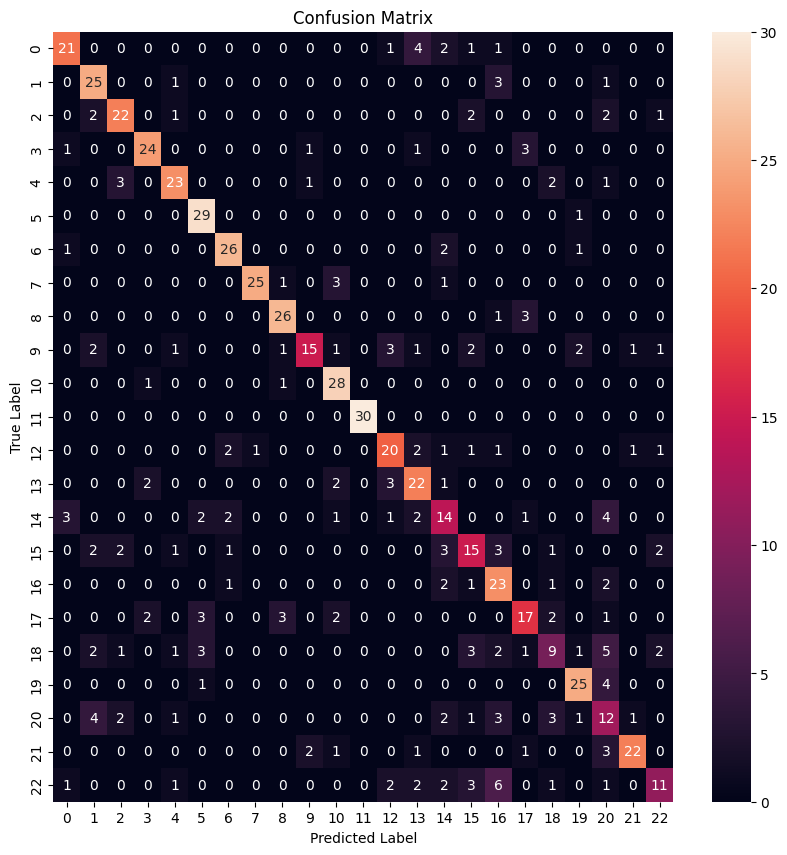

In [36]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import sklearn.metrics
from tensorboardX import SummaryWriter

# Device configuration
device_config = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Active device: {device_config}")

# Model parameters
total_classes = 23
model_hidden_size = 300
lexicon_size = len(vocab)
embed_dim_length = 100

# Embedding setup
embed_layer = nn.Embedding(lexicon_size, embed_dim_length)
embed_vectors = embed_layer.weight.detach()  # Detach to prevent gradient updates

# Model instantiation
author_classifier = TextAuthorClassifier('lstm', total_classes, model_hidden_size, lexicon_size, embed_dim_length, embed_vectors).to(device_config)
model_optimizer = torch.optim.Adam(author_classifier.parameters(), lr=0.01)
classification_loss = nn.CrossEntropyLoss()

# Logging setup
logging_directory = 'runs/lstm_experiment'
iteration_epochs = 1

# Metrics lists
train_accuracy_log = []
train_loss_log = []
test_accuracy_log = []
test_loss_log = []

for iteration in range(20):
    print(f"Starting training run: {iteration + 1}")

    # Execute training
    batch_loss, batch_f1, batch_accuracy = train_classifier(
        model=author_classifier,
        data_loader=train_loader,
        loss_function=classification_loss,
        optimizer=model_optimizer,
        num_epochs=iteration_epochs,
        device=device_config,
        log=logging_directory,
        verbose=True
    )
    preds, true_labels, test_accuracy, test_loss = evaluate_classifier(
        model=author_classifier,
        data_loader=test_loader,
        loss_function=classification_loss,
        device=device_config
    )

    train_accuracy_log.append(batch_accuracy)
    test_accuracy_log.append(test_accuracy)
    train_loss_log.append(batch_loss)
    test_loss_log.append(test_loss)

# Generate confusion matrix
confusion_mat = np.zeros((total_classes, total_classes))
label_pred_pairs = list(zip(true_labels, preds))
for pair in label_pred_pairs:
    confusion_mat[pair] += 1

# Display the confusion matrix
plt.figure(figsize=(10, 10))
sns.heatmap(confusion_mat, annot=True, fmt="g")
plt.title("Confusion Matrix")
plt.ylabel('Actual Label')
plt.xlabel('Predicted Label')
plt.show()


Using device: cuda
Training iteration: 1
---Training statistics--- Epoch: 1 Acc: 0.0714 Loss: 0.0983 F1 Score: 0.0372
Validation statistics: Acc: 0.0957 Loss: 0.1000 
Training iteration: 2
---Training statistics--- Epoch: 1 Acc: 0.2478 Loss: 0.0753 F1 Score: 0.1570
Validation statistics: Acc: 0.3217 Loss: 0.0651 
Training iteration: 3
---Training statistics--- Epoch: 1 Acc: 0.5311 Loss: 0.0478 F1 Score: 0.4305
Validation statistics: Acc: 0.5841 Loss: 0.0433 
Training iteration: 4
---Training statistics--- Epoch: 1 Acc: 0.7770 Loss: 0.0228 F1 Score: 0.7010
Validation statistics: Acc: 0.6928 Loss: 0.0328 
Training iteration: 5
---Training statistics--- Epoch: 1 Acc: 0.9180 Loss: 0.0095 F1 Score: 0.8739
Validation statistics: Acc: 0.7420 Loss: 0.0279 
Training iteration: 6
---Training statistics--- Epoch: 1 Acc: 0.9739 Loss: 0.0033 F1 Score: 0.9556
Validation statistics: Acc: 0.7841 Loss: 0.0253 
Training iteration: 7
---Training statistics--- Epoch: 1 Acc: 0.9901 Loss: 0.0017 F1 Score: 0

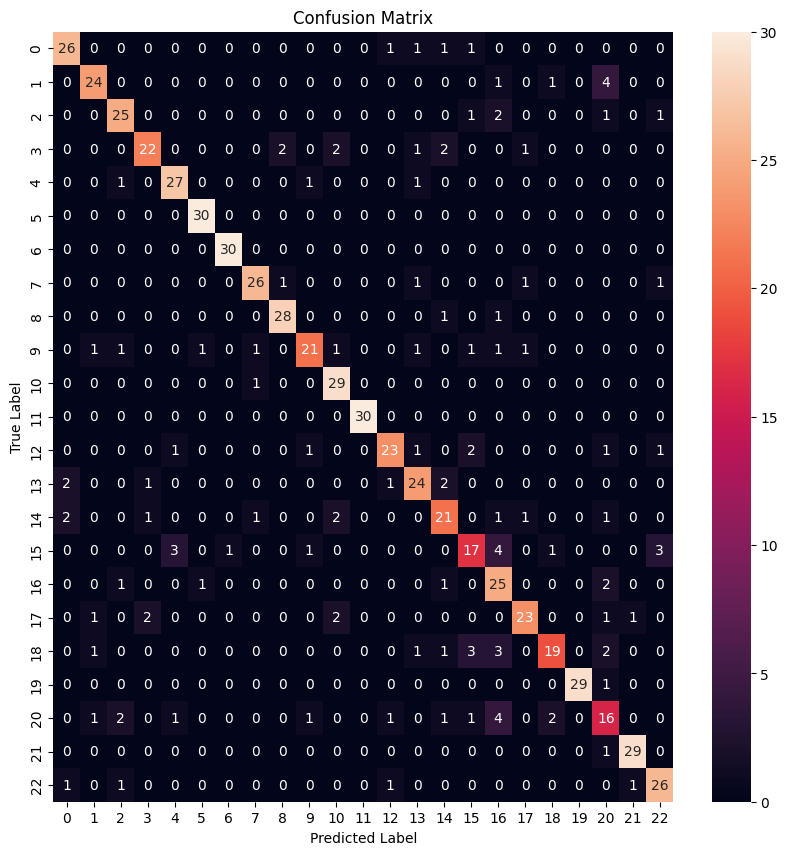

In [33]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import sklearn
# Assuming device is defined somewhere
# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Initialize these outside the loop if you want cumulative learning
compute_device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Compute device selected: {compute_device}")

# Model configuration parameters
num_classes = 23
gru_hidden_size = 300
total_vocab_size = len(vocab)
embedding_size = 100
embedding_layer = nn.Embedding(total_vocab_size, embedding_size)
model_log_dir = 'runs/gru_experiment'

# Model setup for GRU
gru_mode = 'gru'
gru_model = TextAuthorClassifier(gru_mode, num_classes, gru_hidden_size, total_vocab_size, embedding_size, embedding_matrix).to(compute_device)
optimizer = torch.optim.Adam(gru_model.parameters(), lr=0.005)
loss_criterion = nn.CrossEntropyLoss()

# Tracking metrics across iterations
accuracy_train_gru = []
loss_train_gru = []
accuracy_test_gru = []
loss_test_gru = []

for i in range(20):
    print(f"Training iteration: {i+1}")

    # Training
    train_loss, train_f1, train_accuracy = train_classifier(
        model=gru_model,
        data_loader=train_loader,
        loss_function=loss_criterion,
        optimizer=optimizer,
        num_epochs=1,
        device=compute_device,
        log=model_log_dir,
        verbose=True
    )

    # Evaluation phase
    predictions, labels, test_accuracy, test_loss = evaluate_classifier(
        model=gru_model,
        data_loader=test_loader,
        loss_function=loss_criterion,
        device=compute_device
    )

    # Storing metrics
    accuracy_train_gru.append(train_accuracy)
    loss_train_gru.append(train_loss)
    accuracy_test_gru.append(test_accuracy)
    loss_test_gru.append(test_loss)

    # Confusion matrix
confusion_matrix = np.zeros((23, 23))
label_prediction_pairs = list(zip(labels, predictions))
for pair in label_prediction_pairs:
    confusion_matrix[pair] += 1

# Display confusion matrix visualization
plt.figure(figsize=(10, 10))
sns.heatmap(confusion_matrix, annot=True, fmt="g")
plt.title("Confusion Matrix")
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

Using device: cuda
Training iteration: 1
---Training statistics--- Epoch: 1 Acc: 0.0708 Loss: 0.1003 F1 Score: 0.0315
Validation statistics: Acc: 0.1000 Loss: 0.0961 
Training iteration: 2
---Training statistics--- Epoch: 1 Acc: 0.1559 Loss: 0.0901 F1 Score: 0.1016
Validation statistics: Acc: 0.0826 Loss: 0.1032 
Training iteration: 3
---Training statistics--- Epoch: 1 Acc: 0.2124 Loss: 0.0811 F1 Score: 0.1545
Validation statistics: Acc: 0.1971 Loss: 0.0843 
Training iteration: 4
---Training statistics--- Epoch: 1 Acc: 0.3652 Loss: 0.0648 F1 Score: 0.2818
Validation statistics: Acc: 0.2884 Loss: 0.0713 
Training iteration: 5
---Training statistics--- Epoch: 1 Acc: 0.5342 Loss: 0.0471 F1 Score: 0.4476
Validation statistics: Acc: 0.4116 Loss: 0.0610 
Training iteration: 6
---Training statistics--- Epoch: 1 Acc: 0.6832 Loss: 0.0325 F1 Score: 0.5929
Validation statistics: Acc: 0.4522 Loss: 0.0551 
Training iteration: 7
---Training statistics--- Epoch: 1 Acc: 0.7957 Loss: 0.0215 F1 Score: 0

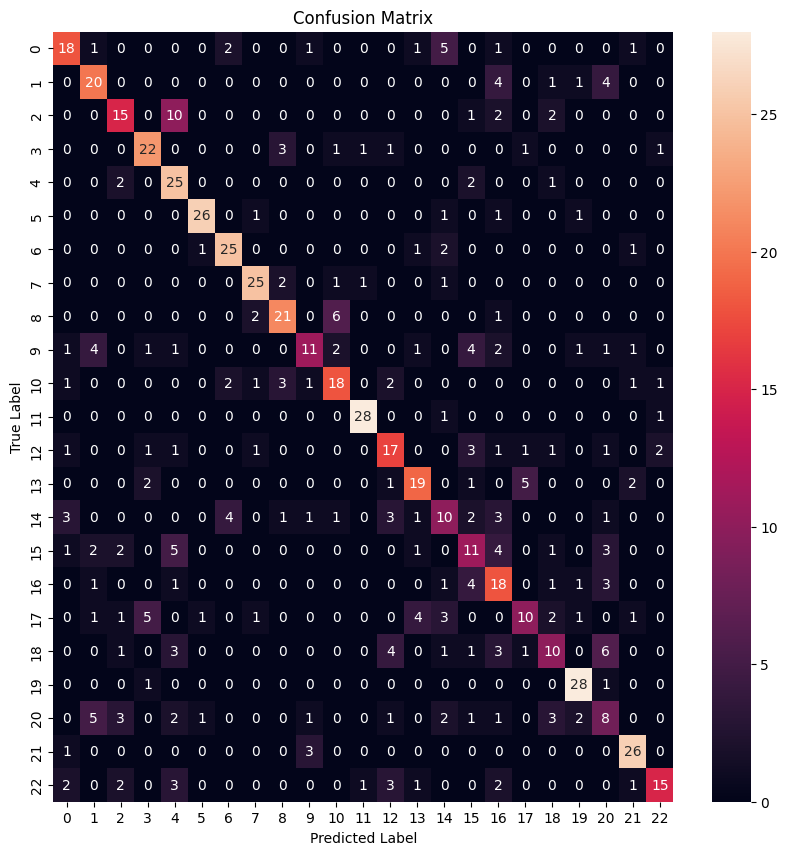

In [20]:

import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.metrics import f1_score
from tensorboardX import SummaryWriter
# Assuming device is defined somewhere
# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Initialize these outside the loop if you want cumulative learning
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")
output_size = 23
hidden_size = 400
vocab_size = len(vocab)
embedding_length = 100
word_embeddings = nn.Embedding(vocab_size, embedding_length)
log_dir = 'runs/bilstm'
loss_function = nn.CrossEntropyLoss()
log_directory = 'runs/bilstm_experiment'

num_epochs = 1
mode = 'bilstm'
# Assuming the embeddings might not be on the correct device or dtype
embedding_weights = word_embeddings.weight  # Detach if needed to avoid unwanted gradient tracking
# Then pass to your model initializer

model_bilstm = TextAuthorClassifier(mode, output_size, hidden_size, vocab_size, embedding_length, embedding_matrix).to(device)
optimizer = torch.optim.Adam(model_bilstm.parameters(), lr=0.01)
loss_function = nn.CrossEntropyLoss()
accuracy_train_log = []
accuracy_test_log = []
f1_score_train_log = []
f1_score_test_log = []
loss_train_log = []
loss_test_log = []
for i in range(20):
    print(f"Training iteration: {i+1}")

    # Training
    train_loss, train_f1, accuracy_train_bilstm = train_classifier(
        model=model_bilstm,
        data_loader=train_loader,
        loss_function=loss_function,
        optimizer=optimizer,
        num_epochs=1,
        device=device,
        log=log_directory,
        verbose=True
    )

    # Evaluate the model
    predictions, labels, accuracy_test_bilstm, test_loss = evaluate_classifier(
        model=model_bilstm,
        data_loader=test_loader,
        loss_function=loss_function,
        device=device
    )

    # Store metrics for analysis
    accuracy_train_log.append(train_accuracy)
    accuracy_test_log.append(test_accuracy)
    f1_score_train_log.append(train_f1)
    f1_score_test_log.append(f1_score(labels, predictions, average='macro'))
    loss_train_log.append(train_loss)
    loss_test_log.append(test_loss)

    # Confusion matrix
conf_matrix = np.zeros((23, 23))
for label, prediction in zip(labels, predictions):
    conf_matrix[label, prediction] += 1

# Plot the confusion matrix
plt.figure(figsize=(10, 10))
sns.heatmap(conf_matrix, annot=True, fmt="g")
plt.title("Confusion Matrix")
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

In [22]:
import plotly.graph_objects as go

# Create a figure object
fig_accuracy = go.Figure()

# Add LSTM training accuracy trace
fig_accuracy.add_trace(go.Scatter(
    y=accuracy_train_log,  # Training accuracy data for LSTM
    mode='lines+markers',    # Use both lines and markers
    name='LSTM Training Accuracy',  # Trace name
    line=dict(color='red', width=2),  # Line color and width
    marker=dict(color='red', size=8)  # Marker settings
))

# Add GRU training accuracy trace
fig_accuracy.add_trace(go.Scatter(
    y=accuracy_train_gru,   # Training accuracy data for GRU
    mode='lines+markers',    # Use both lines and markers
    name='GRU Training Accuracy',  # Trace name
    line=dict(color='green', width=2),  # Line color and width
    marker=dict(color='green', size=8)  # Marker settings
))

# Add BiLSTM training accuracy trace
fig_accuracy.add_trace(go.Scatter(
    y=accuracy_train_bilstm,  # Training accuracy data for BiLSTM
    mode='lines+markers',    # Use both lines and markers
    name='BiLSTM Training Accuracy',  # Trace name
    line=dict(color='blue', width=2),  # Line color and width
    marker=dict(color='blue', size=8)  # Marker settings
))

# Update the layout to add titles and labels
fig_accuracy.update_layout(
    title='Training Accuracy of LSTM, GRU, and BiLSTM Models',
    xaxis_title='Epochs',
    yaxis_title='Accuracy',
    legend_title='Model Type',
    template='plotly_white'  # Use a simple, clean template
)

# Display the figure
fig_accuracy.show()


In [32]:
final_acc_test_gru

[0.14492753623188406,
 0.30869565217391304,
 0.6115942028985507,
 0.6768115942028986,
 0.7434782608695653,
 0.7971014492753623,
 0.8115942028985508,
 0.8333333333333334,
 0.8463768115942029,
 0.8536231884057971,
 0.855072463768116,
 0.8565217391304348,
 0.8565217391304348,
 0.8565217391304348,
 0.855072463768116,
 0.855072463768116,
 0.855072463768116,
 0.8565217391304348,
 0.8565217391304348,
 0.855072463768116]

In [28]:
import plotly.graph_objects as go

# Create a figure object
fig_accuracy = go.Figure()

Transformer_accuracies = [
    0.7043, 0.7978, 0.8283, 0.8696, 0.8826,
    0.8652, 0.8652, 0.8717, 0.8717, 0.8696,
    0.8696, 0.8717, 0.8717, 0.8717, 0.8717,
    0.8717, 0.8717, 0.8717, 0.8696, 0.8717
]

# Add LSTM testing accuracy trace
fig_accuracy.add_trace(go.Scatter(
    y=accuracy_test_log,  # Testing accuracy data for LSTM
    mode='lines+markers',  # Use both lines and markers
    name='LSTM Testing Accuracy',  # Trace name
    line=dict(color='purple', width=2),  # Purple color for LSTM line
    marker=dict(color='purple', size=8)  # Purple markers
))

# Add GRU testing accuracy trace
fig_accuracy.add_trace(go.Scatter(
    y=accuracy_test_gru,  # Testing accuracy data for GRU
    mode='lines+markers',  # Use both lines and markers
    name='GRU Testing Accuracy',  # Trace name
    line=dict(color='orange', width=2),  # Orange color for GRU line
    marker=dict(color='orange', size=8)  # Orange markers
))

# Add BiLSTM testing accuracy trace
fig_accuracy.add_trace(go.Scatter(
    y=accuracy_test_bilstm,  # Testing accuracy data for BiLSTM
    mode='lines+markers',  # Use both lines and markers
    name='BiLSTM Testing Accuracy',  # Trace name
    line=dict(color='teal', width=2),  # Teal color for BiLSTM line
    marker=dict(color='teal', size=8)  # Teal markers
))

# Add Transformer testing accuracy trace
fig_accuracy.add_trace(go.Scatter(
    y=Transformer_accuracies,  # Testing accuracy data for Transformer
    mode='lines+markers',  # Use both lines and markers
    name='Transformer Testing Accuracy',  # Trace name
    line=dict(color='red', width=2),  # Red color for Transformer line
    marker=dict(color='red', size=8)  # Red markers
))

# Update the layout to add titles and labels
fig_accuracy.update_layout(
    title='Testing Accuracy of LSTM, GRU, BiLSTM, and Transformer Models',
    xaxis_title='Epochs',
    yaxis_title='Accuracy',
    legend_title='Model Type',
    template='plotly_white'  # Use a simple, clean template
)

# Display the figure
fig_accuracy.show()



In [63]:
import torch

# Assume 'model' is your trained model.
torch.save(model_lstm.state_dict(), 'lstm.pth')


In [64]:
torch.save(model_bilstm.state_dict(), 'bilstm.pth')


In [65]:
torch.save(model_gru.state_dict(),'gru.pth')

In [94]:
text = """
The most merciful thing in the world, I think, is the inability of the human mind to correlate all its contents. We live on a placid island of ignorance in the midst of black seas of infinity, and it was not meant that we should voyage far. The sciences, each straining in its own direction, have hitherto harmed us little; but some day the piecing together of dissociated knowledge will open up such terrifying vistas of reality, and of our frightful position therein, that we shall either go mad from the revelation or flee from the deadly light into the peace and safety of a new dark age.

Theosophists have guessed at the awesome grandeur of the cosmic cycle wherein our world and human race form transient incidents. They have hinted at strange survivals in terms which would freeze the blood if not masked by a bland optimism. But it is not from them that there came the single glimpse of forbidden eons which chills me when I think of it and maddens me when I dream of it. That glimpse, like all dread glimpses of truth, flashed out from an accidental piecing together of separated things—in this case an old newspaper item and the notes of a dead professor. I hope that no one else will accomplish this piecing out; certainly, if I live, I shall never knowingly supply a link in so hideous a chain. I think that the professor, too, intended to keep silent regarding the part he knew, and that he would have destroyed his notes had not sudden death seized him.

My knowledge of the thing began in the winter of 1926-27 with the death of my grand-uncle, George Gammell Angell, Professor Emeritus of Semitic languages in Brown University, Providence, Rhode Island. Professor Angell was widely known as an authority on ancient inscriptions, and had frequently been resorted to by the heads of prominent museums; so that his passing at the age of ninety-two may be recalled by many. Locally, interest was intensified by the obscurity of the cause of death. The professor had been stricken whilst returning from the Newport boat; falling suddenly, as witnesses said, after having been jostled by a nautical-looking negro who had come from one of the queer dark courts on the precipitous hillside which formed a short cut from the waterfront to the deceased's home in Williams Street. Physicians were unable to find any visible disorder, but concluded after perplexed debate that some obscure lesion of the heart, induced by the brisk ascent of so steep a hill by so elderly a man, was responsible for the end. At the time I saw no reason to dissent from this dictum, but latterly I am inclined to wonder—and more than wonder.

"""

In [104]:
def predict_single_text(text, model, vocab, device):
    model.eval()  # Set the model to evaluation mode
    model.to(device)

    # Tokenize the input text
    tokenizer = get_tokenizer("spacy", language="en_core_web_sm")
    tokens = tokenizer(text.lower())
    indices = [vocab[token] if token in vocab else vocab['<unk>'] for token in tokens]

    # Ensure indices are in the correct type (torch.LongTensor)
    indices_tensor = torch.tensor(indices, dtype=torch.long).unsqueeze(0).to(device)

    # Length of input sequence
    lengths = torch.tensor([len(indices)], dtype=torch.long).to(device)

    with torch.no_grad():
        # Forward pass, ensure that the model and input are compatible
        outputs = model(indices_tensor, lengths)
        
        # Check output dimension and adjust if necessary
        if outputs.dim() == 1:
            outputs = outputs.unsqueeze(0)

        probabilities = torch.nn.functional.softmax(outputs, dim=1)
        predicted_idx = torch.argmax(probabilities, dim=1).item()

    # Return all class probabilities and the predicted class index
    return  predicted_idx , probabilities.squeeze().tolist()



In [144]:
import torch

def predict(model, data_loader, device):
    model.eval()  # Set the model to evaluation mode
    all_probs = []
    all_comment_lengths = []
    
    with torch.no_grad():  # No gradients are needed for making predictions
        for comment, comment_lengths, _ in data_loader:
            comment = comment.to(device)
            comment_lengths = comment_lengths.to(device)
            output = model(comment, comment_lengths)
            probabilities = torch.nn.functional.softmax(output, dim=1)  # Apply softmax to convert logits to probabilities
            all_probs.append(probabilities.cpu().numpy())  # Store probabilities
            all_comment_lengths.extend(comment_lengths.cpu().numpy())  # Store lengths for any potential usage

    return all_probs, all_comment_lengths



all_preds_lstm, all_comment_lengths = predict(model_gru,total_loader,device)

In [145]:
all_preds = all_preds_lstm
all_preds2 = []
for i in range(len(all_preds)): 
    for j in range(len(all_preds[i])): 
        all_preds2.append(all_preds[i][j])


In [146]:
all_preds2 = np.array(all_preds2)

In [147]:
np.savetxt('gru_prediction.csv',all_preds2, delimiter=',')